# House Prices: Advanced Regression Techniques

**Задача** - предсказать цену продажи для каждого дома. Для каждого id из тестового сета, нужно предсказать значение переменной SalePrice.

**Метрика** - сабмиты оцениваются по RMSE (среднеквадратическая ошибка) между логарифмом предсказанного значения и логарифмом реальной цены(использование логарифма означает что ошибки в предсказании дорогих домов и дешевых домов будут иметь влияние на результат равнозначно)

## Общая схема действий согласно кернелам с Kaggle

Здесь распишу общую схему решения и варианты

### План действий
* сделать первый сабмит и закоммитить решение на github
* добавить логарифмирование целевой переменной
* добавить описание столбцов, разбить их на группы, определиться с преобразованиями
* проверить столбцы со скошенным распределением
* удалить столцы, которые мы признали лишними во время анализа
* проверить основные модели для регрессии, которые мы проходили на курсере:
  * линейная регрессия
  * ридж и лассо
  * случайный лес
  * градиентный бустинг

## 1. EDA (Разведочный анализ данных, Exploratory data analysis)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn import model_selection, linear_model, metrics, preprocessing, pipeline

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

Считываем тренировочные данные:

In [3]:
train_data = pd.read_csv("data/train.csv")

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# выводим список всех столбцов
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
# Смотрим какие типы столбцов присутствуют в данных
train_data.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

In [7]:
# Проверяем есть ли пропуски в данных
train_data.isnull().values.any()

True

Создадим два списка признаков, соответствующие их группам: числовые и категориальные (эти списки даны на странице соревнования). Уберем признак Id, так как он не несет смысловой нагрузки.

In [8]:
numerical_features = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt','LotArea', 'YearBuilt', 
                     'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                     'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
                     'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                      '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
                     'BedroomAbvGr', 'KitchenAbvGr']
cat_features = train_data.columns.drop(numerical_features).drop(["Id", "SalePrice"]).tolist()

In [9]:
print(len(numerical_features), len(cat_features))

33 46


In [10]:
train_data[numerical_features].get_dtype_counts()

float64     3
int64      30
dtype: int64

In [11]:
train_data[cat_features].get_dtype_counts()

int64      3
object    43
dtype: int64

In [12]:
train_data[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 46 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1452 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 no

### Анализируем целевую переменную

In [13]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Минимальная цена дома больше нуля и выглядит адекватной

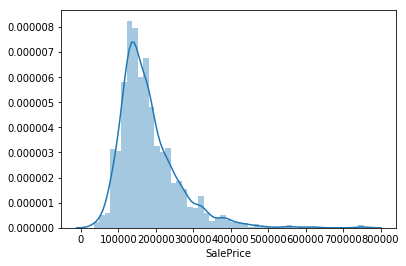

In [14]:
seaborn.distplot(train_data['SalePrice']);

Величина не распределена нормально. Имеется перекос вправо.

In [15]:
#skewness and kurtosis
print("Перекос: %f" % train_data['SalePrice'].skew())
print("Куртозис: %f" % train_data['SalePrice'].kurt())

Перекос: 1.882876
Куртозис: 6.536282


Куртозис (kurtosis) - Коэффициент эксцесса (коэффициент островершинности) в теории вероятностей — мера остроты пика распределения случайной величины. - является показателем, отражающим остроту вершины и толщину хво- стов одномерного распределения.

**Связь с цифровыми признаками**

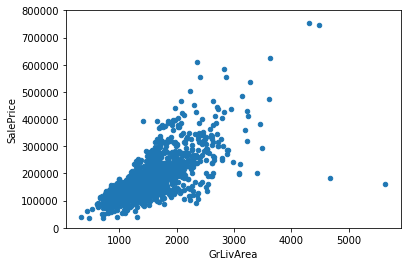

In [16]:
var = 'GrLivArea'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Имеет место линиейная зависимость между жилой площадью и стоимостью дома

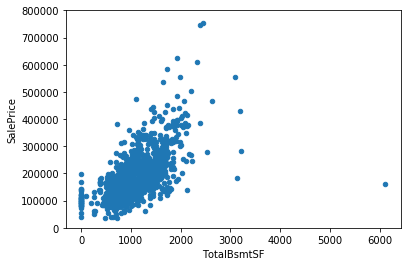

In [17]:
var = 'TotalBsmtSF'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Здесь также имеет место линейная зависимость но с большим разбросом

**Связь с категориальными признаками**

(-0.5, 9.5, 0, 800000)

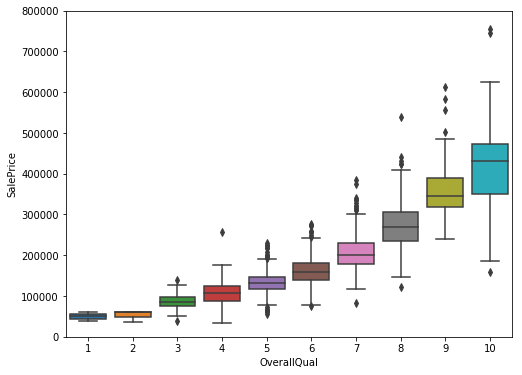

In [18]:
#box plot overallqual/saleprice
var = 'OverallQual' # Видимо общее состояние
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = seaborn.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 111.5, 0, 800000)

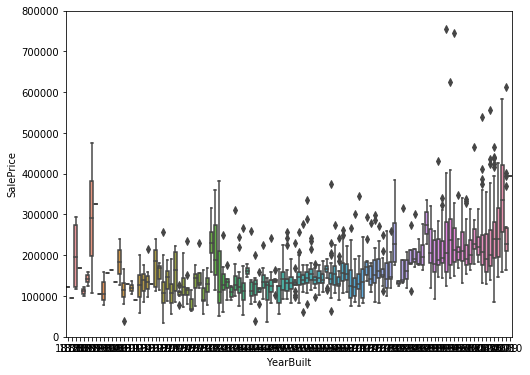

In [19]:
#box plot overallqual/saleprice
var = 'YearBuilt' # Видимо общее состояние
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = seaborn.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

### Анализ признаков

**Строим матрицу корреляции признаков между собой**

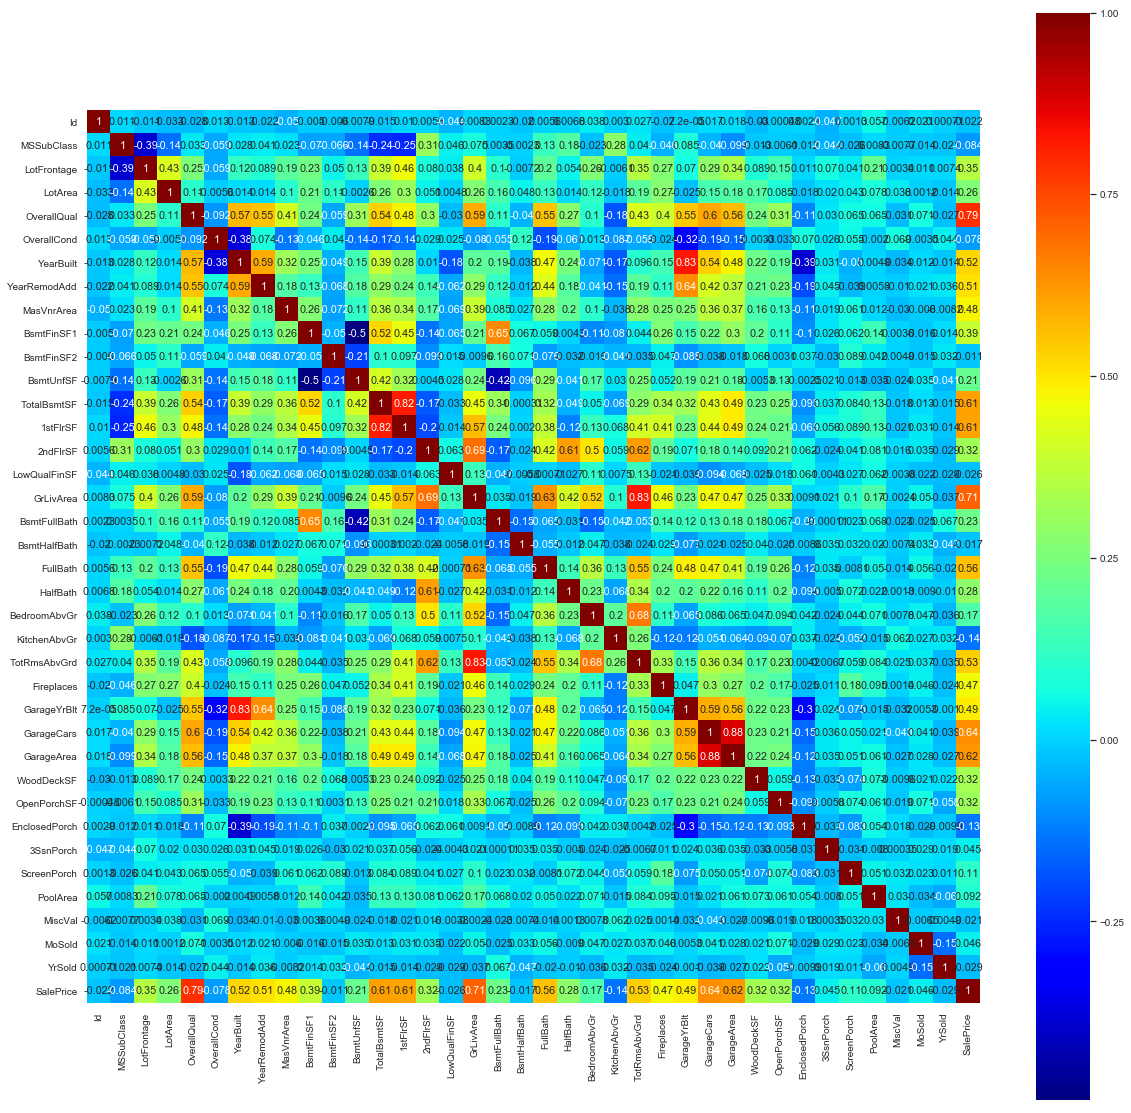

In [20]:
corrmat = train_data.corr()
seaborn.set(font_scale=0.9)
fig, axes = plt.subplots(figsize=(20,20))
seaborn.heatmap(corrmat, square=True, annot=True, cmap='jet')

**Строим матрицу корреляции SalePrice**

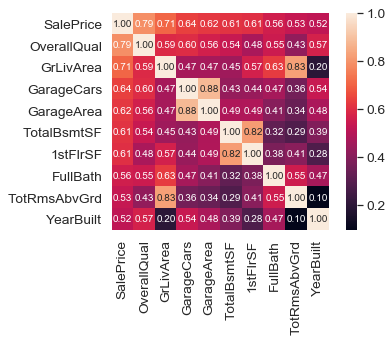

In [21]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
seaborn.set(font_scale=1.25)
hm = seaborn.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Здесь можно увидеть признаки наиболее коррелирующие с SalePrice**

GarageCars и GarageArea очень сильно коррелируют - можно оставить только GarageCars т.к. его корреляция с SalePrice выше

у TotalBsmtSF и 1stFloor такая же ситуация

TotRmsAbvGrd and GrLivArea аналогично

## 2. Data Cleaning and Data Preparation

**Нужно пилить пайплайн!!!!!!!!!!!!!!!!!**

Общая последовательность обработки данных, которой я планирую придерживаться:
* разделяем выборку на трейн и тест
* собираем пайплайн с избранными моделями
* подбор параметров по сетке
* оценка по отложенному тесту



### Разделяем выборку на трейн и тест

In [22]:
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']
X.shape

(1460, 79)

**Заполнаем пропущенные значения**

In [23]:
# Понравилось как здесь заполнили пропущенные значения:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

**Разделяем на выборку и тест**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=0)

Посмотреть распределения целевой метки:

Text(0.5, 1.0, 'test_data')

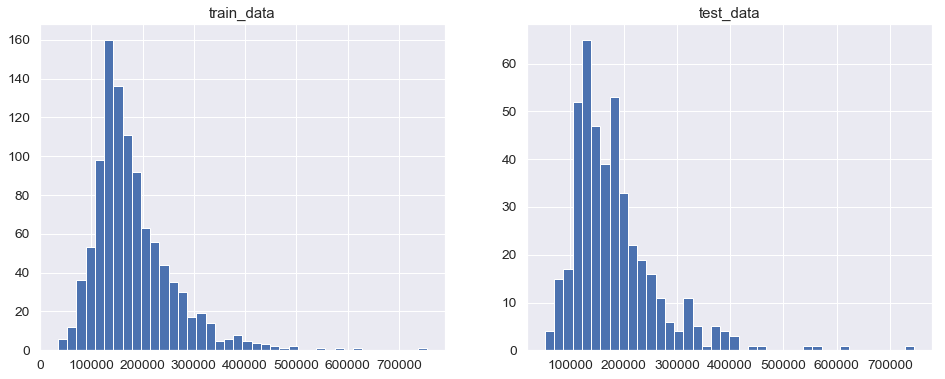

In [25]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.hist(y_train, bins=40)
plt.title('train_data')

plt.subplot(1,2,2)
plt.hist(y_test, bins=40)
plt.title('test_data')

In [26]:
# выделить бинарные, категориальные и числовые признаки
binary_data_columns = []
binary_data_indices = np.array([(column in binary_data_columns) for column in X.columns], dtype = bool)

In [27]:
print(binary_data_columns)
print(binary_data_indices)

[]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


In [28]:
categorical_data_columns = cat_features
categorical_data_indices = np.array([(column in categorical_data_columns) for column in X.columns], 
                                    dtype = bool)

In [29]:
print(len(categorical_data_columns))
print(len(categorical_data_indices))

46
79


In [30]:
numeric_data_columns = numerical_features
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X.columns], 
                               dtype = bool)

In [31]:
print(len(numeric_data_columns))
print(len(numeric_data_indices))

33
79


### Transformer Objects

In [32]:
from sklearn.base import TransformerMixin, BaseEstimator, clone

class SelectColumnsTransfomer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides column selection
    
    Allows to select columns by name from pandas dataframes in scikit-learn
    pipelines.
    
    Parameters
    ----------
    columns : list of str, names of the dataframe columns to select
        Default: [] 
    
    """
    def __init__(self, columns=[]):
        self.columns = columns

    def transform(self, X, **transform_params):
        """ Selects columns of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
            
        Returns
        ----------
        
        trans : pandas DataFrame
            contains selected columns of X      
        """
        trans = X[self.columns].copy() 
        return trans
    
    def fit(self, X, y=None, **fit_params):
        """ Do nothing function
        
        Parameters
        ----------
        X : pandas DataFrame
        y : default None
                
        
        Returns
        ----------
        self  
        """
        return self

In [33]:
class DataFrameFunctionTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer providing imputation or function application
    
    Parameters
    ----------
    impute : Boolean, default False
        
    func : function that acts on an array of the form [n_elements, 1]
        if impute is True, functions must return a float number, otherwise 
        an array of the form [n_elements, 1]
    
    """
    
    def __init__(self, func, impute = False):
        self.func = func
        self.impute = impute
        self.series = pd.Series() 

    def transform(self, X, **transformparams):
        """ Transforms a DataFrame
        
        Parameters
        ----------
        X : DataFrame
            
        Returns
        ----------
        trans : pandas DataFrame
            Transformation of X 
        """
        
        if self.impute:
            trans = pd.DataFrame(X).fillna(self.series).copy()
        else:
            trans = pd.DataFrame(X).apply(self.func).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Fixes the values to impute or does nothing
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
                
        Returns
        ----------
        self  
        """
        
        if self.impute:
            self.series = pd.DataFrame(X).apply(self.func).copy()
        return self

In [34]:
class DataFrameFeatureUnion(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that unites several DataFrame transformers
    
    Fit several DataFrame transformers and provides a concatenated
    Data Frame
    
    Parameters
    ----------
    list_of_transformers : list of DataFrameTransformers
        
    """ 
    def __init__(self, list_of_transformers):
        self.list_of_transformers = list_of_transformers
        
    def transform(self, X, **transformparamn):
        """ Applies the fitted transformers on a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        concatted :  pandas DataFrame
        
        """
        
        concatted = pd.concat([transformer.transform(X)
                            for transformer in
                            self.fitted_transformers_], axis=1).copy()
        return concatted
    
    def fit(self, X, y=None, **fitparams):
        """ Fits several DataFrame Transformers
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
        
        Returns
        ----------
        self : object
        """
        
        self.fitted_transformers_ = []
        for transformer in self.list_of_transformers:
            fitted_trans = clone(transformer).fit(X, y=None, **fitparams)
            self.fitted_transformers_.append(fitted_trans)
        return self

In [35]:
class ToDummiesTransformer(BaseEstimator, TransformerMixin):
    """ A Dataframe transformer that provide dummy variable encoding
    """
    
    def transform(self, X, **transformparams):
        """ Returns a dummy variable encoded version of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        trans : pandas DataFrame
        
        """
    
        trans = pd.get_dummies(X).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Do nothing operation
        
        Returns
        ----------
        self : object
        """
        return self

In [36]:
class DropAllZeroTrainColumnsTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides dropping all-zero columns
    """

    def transform(self, X, **transformparams):
        """ Drops certain all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        
        Returns
        ----------
        trans : DataFrame
        """
        
        trans = X.drop(self.cols_, axis=1).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Determines the all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        y : not used
        
        Returns
        ----------
        self : object
        """
        
        self.cols_ = X.columns[(X==0).all()]
        return self

### Cобираем пайплайн

In [37]:
from sklearn.pipeline import Pipeline, make_pipeline

**Столбцы площади**

Мы начнем со столбцов описывающих всевозможные площади. Столбцы со скошенным распределением должны быть прологорифмированны. Просмотрев данные, можно заметить что столбцы со скошенными распределениями это столбцы площади.

Для определения столбцов с площадью используем регулярное выражение, затем преобразуем значения к флоат, заполним пустые значения средними значенимяи и применим log(x+1) трансформацию.

In [38]:
area_cols = X_train.columns[X_train.columns.str.contains('(?i)area|(?i)porch|(?i)sf')].tolist()

area_cols_pipeline = make_pipeline(  
        SelectColumnsTransfomer(area_cols),
        DataFrameFunctionTransformer(func = lambda x: x.astype(np.float64)),
        DataFrameFunctionTransformer(func = np.mean, impute=True),
        DataFrameFunctionTransformer(func = np.log1p) 
    )

**Столбцы объектов**

The object columns are the categorical columns. Reading the data set description, we see that NaN values are allowed for each column. Consequently, we assume that possible levels of the categorical values are known beforehand and that the NaNs are correctly encoded. So though we access the values of the test data, we don't use information not known before the analyzing the data

So what we will do here is to determine all possible levels across all categories, construct dummy variables for all variables and levels (this is not efficient!) and then drop the combinations that do not occur. Particularly, when fitting the pipeline to the training data sets and applying to the test sets, we will only keep levels contained in the training data sets!

We simply filter the columns by data type, construct the object levels, impute, convert to dummy notation and drop all zero columns

In [39]:
object_columns = X_train.columns[X_train.dtypes == object].tolist()
object_levels = np.union1d(X_train[object_columns].fillna('NAN'), X_test[object_columns].fillna('NAN'))

categorical_cols_pipeline = make_pipeline(
        SelectColumnsTransfomer(object_columns),
        DataFrameFunctionTransformer(lambda x:'NAN', impute=True),
        DataFrameFunctionTransformer(lambda x:x.astype('category', categories=object_levels)),
        ToDummiesTransformer(),
        DropAllZeroTrainColumnsTransformer()
    )

**Переименование столбцов**

The remaining columns are mostly integer columns. However, if an integers column in a training set has a missing value in the test set the data type will be float in the test set. So, without actually using information beforehand, we just convert the remaining columns to float, store the mean and impute if necessary on train and test sets.

Typically, integer columns provide some form of count data, hence we do not use a log transform here. Note however, that the GarageBltYear is also a remaining column. For simplicity, we treat it like the other count-like columns

In [40]:
remaining_cols = [x for x in X_train.columns.tolist() if x not in object_columns and x not in area_cols]

remaining_cols_pipeline = make_pipeline(
        SelectColumnsTransfomer(remaining_cols),
        DataFrameFunctionTransformer(func = lambda x: x.astype(np.float64)),
        DataFrameFunctionTransformer(func = np.mean, impute=True)
    )

**Используем пайплайн**

We put the pipelines together using the DataFrameFeatureUnion transformer. To demonstrate that we get a DataFrame we simply use fit_transform on the training set and show the first rows

In [41]:
preprocessing_features = DataFrameFeatureUnion([area_cols_pipeline, categorical_cols_pipeline, 
                                                remaining_cols_pipeline])
preprocessing_features.fit_transform(X_train).head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MiscVal,MoSold,YrSold
64,9.145909,6.352629,6.606650,0.0,5.765191,6.964136,6.964136,6.885510,0.0,7.618251,...,1.0,3.0,1.0,8.0,0.0,1998.000000,2.0,0.0,2.0,2009.0
682,7.968320,0.000000,6.911747,0.0,5.666427,7.163947,7.163947,0.000000,0.0,7.163947,...,0.0,2.0,1.0,6.0,1.0,1996.000000,2.0,0.0,11.0,2008.0
960,8.882947,0.000000,6.546785,0.0,5.093750,6.755769,6.755769,0.000000,0.0,6.755769,...,0.0,2.0,1.0,4.0,0.0,1978.012397,0.0,0.0,2.0,2010.0
1384,9.111735,0.000000,5.323010,0.0,5.877736,6.329721,6.549651,6.329721,0.0,7.138073,...,0.0,2.0,1.0,6.0,0.0,1939.000000,1.0,0.0,10.0,2009.0
1100,9.036106,0.000000,5.673323,0.0,0.000000,5.673323,6.084499,0.000000,0.0,6.084499,...,0.0,1.0,1.0,3.0,0.0,1930.000000,1.0,0.0,1.0,2009.0


**Gridsearch and Crossvalidation**

We use nested cross validation to estimate the generalization performance. See the 3rd example here

Unfortunately, nested cross validation is not able to return the best model parameters for each fold (and probably never will be). However, for simplicity, we just assume that the model parameters are stable across the cross validation folds on the training sets.

In [42]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
pipe_ridge = make_pipeline(preprocessing_features, Ridge())
param_grid = {'ridge__alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}
pipe_ridge_gs = GridSearchCV(pipe_ridge, param_grid=param_grid, scoring = 'neg_mean_squared_error', cv=3)
result = np.sqrt(-cross_val_score(pipe_ridge_gs, X_train, np.log(y_train), scoring = 'neg_mean_squared_error', cv = 5))
np.mean(result)

0.12485103619812041

### Оценка по отложенному тесту

So the result is relatively close to that of Alexandra Papiu. But I was not yet able to figure out where the differences come from exactly. One differnece is that I seem to construct more columns.

Let me comment on the scoring parameter. Why 'neg_mean_squared_error'? This is a scikit learn convention that ensures that grid search and cross validation always maximize a specific score.

Additionally, you might want to ask, why we don't use a custom scoring function and than use y_train instead of np.log(y_train). The reason is simply, that the loss functions in the algorithms are typically some form of squared loss. Using the np.log transformation, the optimization during model training directly optimizes the correct loss function. If we use a custom scorer object, the internal optimization is performed using standard quadratic error functional and we simply evaluate the results using that custom scorer. Those results do not necessarily have to be the same and perform worse in general (you can even test it here).

For completeness, let us just fit an optimized model on the full training data and provide a data set for submission

In [43]:
pipe_ridge_gs.fit(X_train, np.log(y_train))
predicted = pipe_ridge_gs.predict(X_test)

In [44]:
metrics.mean_absolute_error(np.log(y_test), predicted)

0.08393530477461687

In [45]:
print(y_test[:10])

529     200624
491     133000
459     110000
279     192000
655      88000
1013     85000
1403    282922
601     141000
1182    745000
687     148800
Name: SalePrice, dtype: int64


In [46]:
print(pipe_ridge_gs.predict(X_test)[:10])

[12.39873676 11.89317462 11.72169706 12.35643723 11.4670206  11.45208575
 12.47713676 11.70028858 13.29871633 11.98232323]


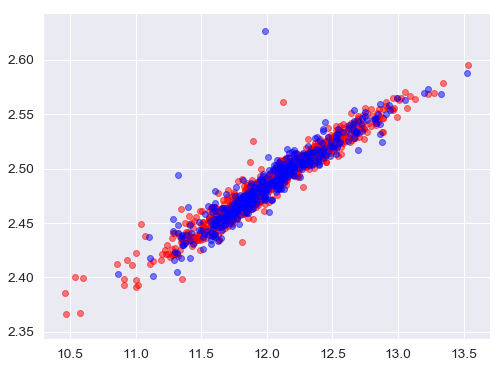

In [47]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.scatter(np.log(y_train), np.log(pipe_ridge_gs.predict(X_train)), alpha=0.5, color = 'red')
plt.scatter(np.log(y_test), np.log(pipe_ridge_gs.predict(X_test)), alpha=0.5, color = 'blue')

## Test data calculations

In [48]:
df_test = pd.read_csv("data/test.csv")
X_test = df_test.set_index("Id")

In [49]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [50]:
predicted = np.exp(pipe_ridge_gs.predict(X_test))
X_test["SalePrice"] = predicted
X_test["SalePrice"].to_csv('pipe_ridge_gs.csv', header=True)
pipe_ridge_gs.best_params_

{'ridge__alpha': 5}

In [51]:
X_test["SalePrice"].head()

Id
1461    114407.915384
1462    163017.668219
1463    180954.465455
1464    196889.550522
1465    192844.013102
Name: SalePrice, dtype: float64

## Разобрать следующие кернелы:

In [52]:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5

# https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding

# избавиться от выбросов
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# https://www.kaggle.com/ctrlaltz/final-model

# https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1

# https://www.kaggle.com/kb2900/house-prices-from-data-cleaning-to-modeling

# pipelines:
# https://www.kaggle.com/jankoch/scikit-learn-pipelines-and-pandas
# https://www.kaggle.com/kabure/houseprices-pipeline-featuretools-tpot